In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('C://Users//demey//Documents//2024-2025//Industry Project//Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)
print(core_X_data.isna().sum())  # should all be zero

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())

gender                0
age                   0
height                0
weight                0
bmi                   0
family_hist_cnt       0
chronic_meds_cnt      0
procedure_category    0
antibiotics           0
CM_AIDS               0
CM_ANEMDEF            0
CM_ARTH               0
CM_CHF                0
CM_DEPRESS            0
CM_DM                 0
CM_DMCX               0
CM_HTN_C              0
CM_HYPOTHY            0
CM_LIVER              0
CM_OBESE              0
CM_PSYCH              0
CM_SMOKE              0
CM_APNEA              0
CM_CHOLSTRL           0
CM_OSTARTH            0
CM_HPLD               0
dtype: int64
Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']
Remaining columns in CM data: ['CM_AIDS', 'CM_ANEMDEF', 'CM_ARTH', 'CM_CHF', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_HTN_C', 

In [4]:
#Add intra-operative columns
intra_op_cols = ['cvp', 'cvp_a_line', 'cvp_catheter', 'cvp_dvt_pumps','stapling', 'peritoneal_defects', 'bloodloss', 'bloodloss_amt', 'sheath_closure', 'sheath_closure_option', 'TheaterTotalTime', 'SurgeryTotalTime', 'wound_closure', 'post_op', 'regional_block', 'approach', 'drain','common_channel_length', 'billiary_limb_length','allimentary_limb_length','total_bowel_length', 'cholecystectomy_repair', 'incisional_hernia_repair','hiatus_hernia_repair']
intra_op_data = df[intra_op_cols].copy()

MISSING VALUES ANALYSIS
Columns with missing values: 4/24
Total completeness: 94.9%

Top missing columns:
                    Missing_Count  Missing_Percentage
bloodloss_amt                 189           54.941860
regional_block                156           45.348837
peritoneal_defects             64           18.604651
approach                       14            4.069767


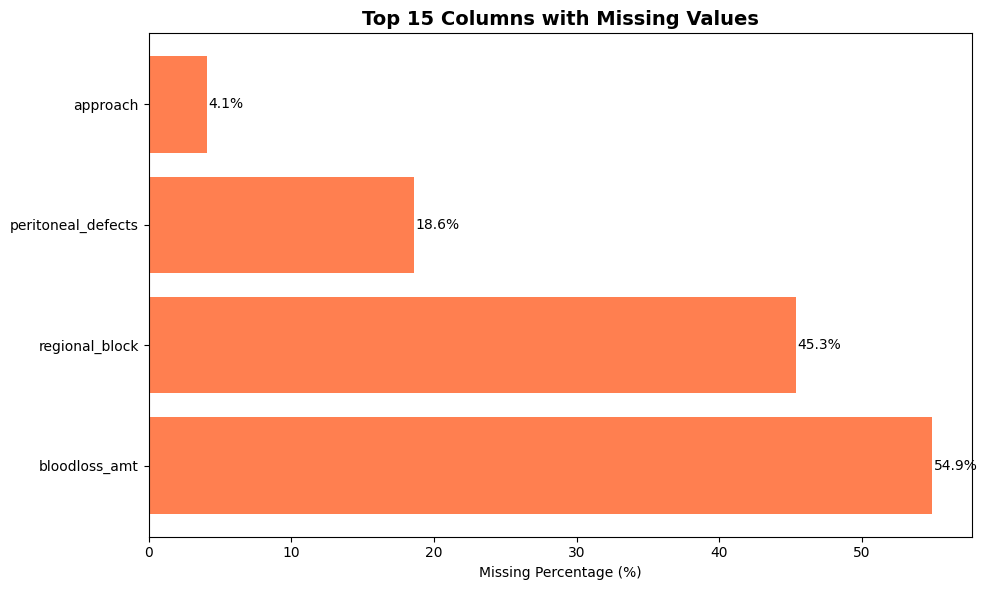

In [5]:
# Missing values analysis
missing_df = pd.DataFrame({
    'Missing_Count': intra_op_data.isnull().sum(),
    'Missing_Percentage': (intra_op_data.isnull().sum() / len(intra_op_data)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
print(f"Columns with missing values: {len(missing_df)}/{intra_op_data.shape[1]}")
print(f"Total completeness: {(1 - intra_op_data.isnull().sum().sum()/(intra_op_data.shape[0]*intra_op_data.shape[1]))*100:.1f}%")

if len(missing_df) > 0:
    print("\nTop missing columns:")
    print(missing_df.head(10))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    top_missing = missing_df.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(top_missing['Missing_Percentage']):
        plt.text(v + 0.1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

In [6]:
intra_op_data['bloodloss_amt'] = intra_op_data['bloodloss_amt'].fillna(0)
intra_op_data['approach'] = intra_op_data['approach'].fillna('Open')

In [7]:
intra_op_data.head(300)

,cvp,cvp_a_line,cvp_catheter,cvp_dvt_pumps,stapling,peritoneal_defects,bloodloss,bloodloss_amt,sheath_closure,sheath_closure_option,...,regional_block,approach,drain,common_channel_length,billiary_limb_length,allimentary_limb_length,total_bowel_length,cholecystectomy_repair,incisional_hernia_repair,hiatus_hernia_repair
0,0,0,0,1,Covidien,Prolene,1,100.0,0,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,0
1,0,0,0,0,Echelon,Prolene,0,0.0,0,PDS,...,TAPP,Laproscopic,0,0,0,0,0,1,0,0
2,0,0,0,1,Panther,Prolene,0,0.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
3,0,0,0,0,Panther,NaN,0,0.0,0,PDS,...,NaN,Laproscopic,0,0,0,0,0,0,0,1
4,0,0,1,1,Panther,Prolene,1,250.0,1,PDS,...,TAPP,Laproscopic,1,300,570,0,870,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,Covidien,Prolene,0,0.0,0,PDS,...,NaN,Open,0,0,200,0,0,0,0,0
296,0,0,0,1,Panther,Prolene,1,100.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,1,0,1
297,0,0,0,1,Covidien,NaN,0,0.0,0,PDS,...,NaN,Laproscopic,0,0,220,0,0,0,0,0
298,0,0,0,1,Covidien,Prolene,0,0.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1


In [8]:
core_X_data = core_X_data.join(intra_op_data)
core_X_data

,gender,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,procedure_category,antibiotics,CM_AIDS,...,regional_block,approach,drain,common_channel_length,billiary_limb_length,allimentary_limb_length,total_bowel_length,cholecystectomy_repair,incisional_hernia_repair,hiatus_hernia_repair
0,Female,50,154,146.0,61.56,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,0
1,Female,52,168,96.0,34.00,0,0,Sleeve,Kefsol,0,...,TAPP,Laproscopic,0,0,0,0,0,1,0,0
2,Female,23,163,143.0,53.82,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
3,Female,23,176,120.0,38.74,0,0,Sleeve,Kefsol,0,...,NaN,Laproscopic,0,0,0,0,0,0,0,1
4,Female,57,162,112.0,42.68,0,7,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,570,0,870,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Female,24,173,145.0,48.45,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,320,0,620,0,0,1
340,Female,26,149,73.4,33.06,0,0,Mini gastric bypass (OAGB),Augmentin,0,...,NaN,Laproscopic,0,700,220,0,0,0,0,0
341,Female,24,180,153.0,47.22,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
342,Female,25,165,154.0,56.57,0,0,RYGBP,Augmentin,0,...,NaN,Laproscopic,0,0,150,80,0,0,0,0


In [9]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [10]:
core_Y_data=df_new[["complication"]]

core_Y_data.head()

,complication
0,0
1,0
2,1
3,0
4,0


In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = core_X_data.copy()
y = core_Y_data['complication'].values

# Handle categorical variables first
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


X_encoded.head()

,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,CM_AIDS,CM_ANEMDEF,CM_ARTH,CM_CHF,...,peritoneal_defects_Stratfix,peritoneal_defects_V-lock,sheath_closure_option_PDS,wound_closure_Monocryl,wound_closure_V lock,wound_closure_Vicryl Rapide,post_op_ICU,post_op_Ward,regional_block_TAPP,approach_Open
0,50,154,146.0,61.56,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
1,52,168,96.0,34.00,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
2,23,163,143.0,53.82,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
3,23,176,120.0,38.74,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
4,57,162,112.0,42.68,0,7,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False


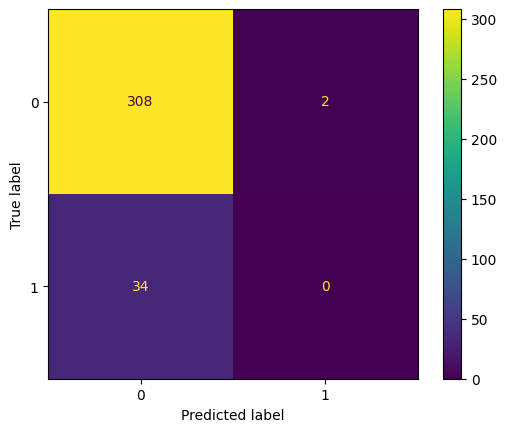

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use this instead of RandomForestRegressor if you're classifying
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Generate predictions
y_pred = cross_val_predict(model, X_encoded, y, cv=5)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'randomforestclassifier__n_estimators': randint(100, 1000),
    'randomforestclassifier__max_depth': [None] + list(range(5, 31, 5)),
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

search.fit(X_encoded, y)

print("Best params:", search.best_params_)
print("Best cross-val accuracy:", search.best_score_)

Best params: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 171}
Best cross-val accuracy: 0.9011935208866155


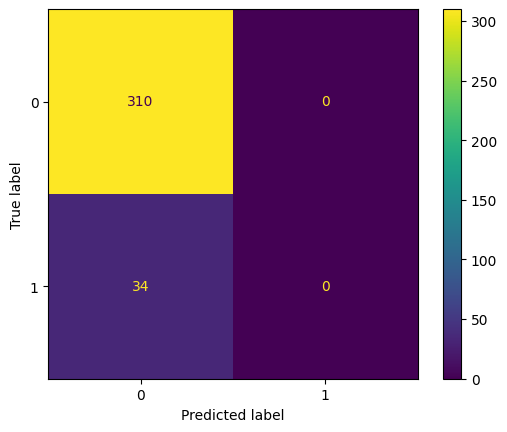

In [14]:
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=171,
        max_depth=30,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=10,
        random_state=42
    )
)

y_pred = cross_val_predict(model, X_encoded, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

Best threshold for F1: 0.12
Precision: 0.16, Recall: 0.71, F1: 0.27


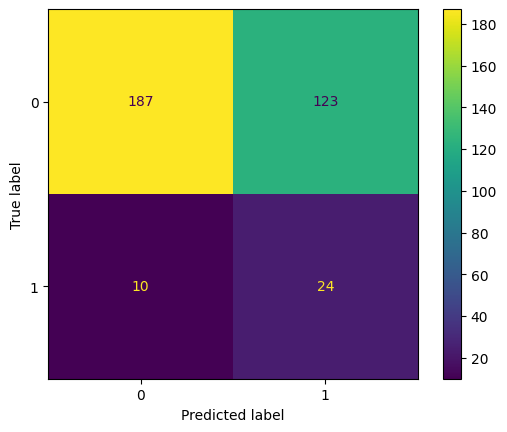

In [15]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get probabilities as before
y_proba = cross_val_predict(model, X_encoded, y, cv=5, method='predict_proba')[:, 1]

# Precision-recall threshold sweep
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Compute F1 score at each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold for F1: {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1s[best_idx]:.2f}")

# Apply best threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred_opt)
ConfusionMatrixDisplay(cm).plot()
plt.show()


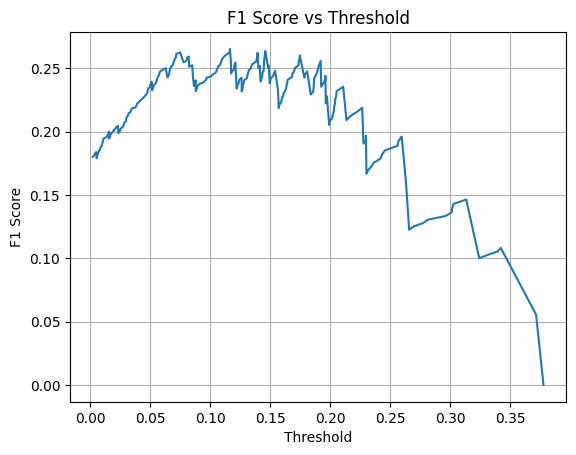

In [16]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1s[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import precision_recall_curve, f1_score

# Probabilities from cross-validated model
y_proba = cross_val_predict(model, X_encoded, y, cv=5, method='predict_proba')[:, 1]

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Trim so thresholds match
thresholds = np.append(thresholds, 1.0)  # to match length of precisions/recalls

# Print threshold sweep for class 1
for t, p, r in zip(thresholds, precisions, recalls):
    if r >= 0.6 and p >= 0.3:  # adjust these as your desired minimums
        print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {2*p*r/(p+r + 1e-8):.2f}")

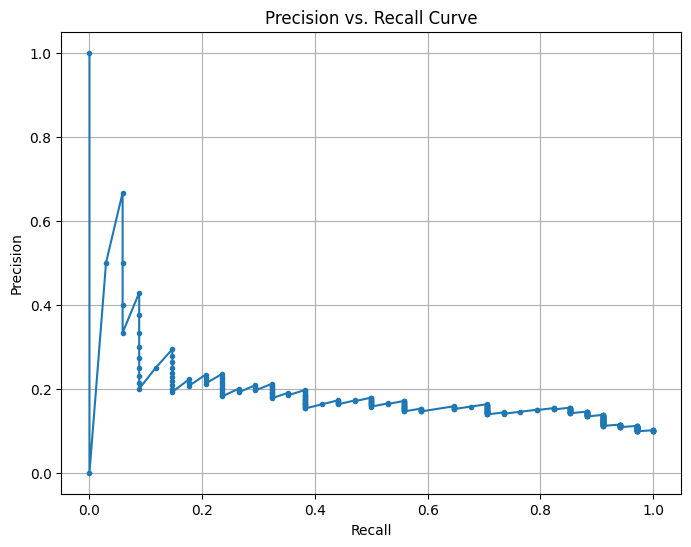

In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities (already done earlier)
y_proba = cross_val_predict(model, X_encoded, y, cv=5, method='predict_proba')[:, 1]

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Curve')
plt.grid(True)
plt.show()


In [19]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
all_thresholds = []
all_f1_scores = []

# Cross-validation loop
for train_idx, test_idx in cv.split(X_encoded, y):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]  # <-- no .iloc here

    # Undersample the majority class in training set only
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    # Train model
    model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    model.fit(X_resampled, y_resampled)

    # Predict probabilities on test set
    y_proba = model.predict_proba(X_test)[:, 1]

    # Find precision-recall curve for threshold tuning
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # Compute F1 scores for all thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    all_thresholds.append(best_threshold)
    all_f1_scores.append(best_f1)

    print(f"Fold best threshold: {best_threshold:.3f}, F1: {best_f1:.3f}")

# Overall results
print("\nAverage best threshold:", np.mean(all_thresholds))
print("Average F1 score:", np.mean(all_f1_scores))


Fold best threshold: 0.066, F1: 0.235
Fold best threshold: 0.765, F1: 0.455
Fold best threshold: 0.025, F1: 0.245
Fold best threshold: 0.881, F1: 0.359
Fold best threshold: 0.994, F1: 0.364

Average best threshold: 0.54606078969464
Average F1 score: 0.33146965076326135


In [20]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# 1️⃣ Refit model on full dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_encoded, y)

final_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
final_model.fit(X_resampled, y_resampled)

# 2️⃣ Set your final threshold
final_threshold = np.mean(all_thresholds)
print(f"Deployment threshold: {final_threshold:.3f}")

# 3️⃣ Predict on full dataset (or new unseen dataset if you have it)
y_proba_full = final_model.predict_proba(X_encoded)[:, 1]

# Apply threshold to get final predictions
y_pred_final = (y_proba_full >= final_threshold).astype(int)

# 4️⃣ Evaluation metrics

cm = confusion_matrix(y, y_pred_final)
precision = precision_score(y, y_pred_final, zero_division=0)
recall = recall_score(y, y_pred_final, zero_division=0)
f1 = f1_score(y, y_pred_final, zero_division=0)

print("\nConfusion Matrix:")
print(cm)
print("\nPrecision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))

# Optional: full classification report
print("\nClassification Report:")
print(classification_report(y, y_pred_final, zero_division=0))


Deployment threshold: 0.546

Confusion Matrix:
[[197 113]
 [  8  26]]

Precision: 0.187
Recall: 0.765
F1 Score: 0.301

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77       310
           1       0.19      0.76      0.30        34

    accuracy                           0.65       344
   macro avg       0.57      0.70      0.53       344
weighted avg       0.88      0.65      0.72       344



In [21]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store thresholds and scores
all_thresholds = []
all_scores = []

# Custom utility function: prioritize recall more heavily
def custom_utility(precision, recall):
    return (3 * precision * recall) / (precision + recall + 1e-10)

for train_idx, test_idx in cv.split(X_encoded, y):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Undersample majority class in train set
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    # Calculate scale_pos_weight for XGBoost
    pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

    # Train XGBoost model
    model = xgb.XGBClassifier(scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_resampled, y_resampled)

    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    # Threshold optimization
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    utility_scores = custom_utility(precision, recall)
    best_idx = np.argmax(utility_scores)
    best_threshold = thresholds[best_idx]
    best_score = utility_scores[best_idx]

    all_thresholds.append(best_threshold)
    all_scores.append(best_score)

    print(f"Fold threshold: {best_threshold:.3f}, Utility Score: {best_score:.3f}")

# Deployment: train on full dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_encoded, y)
pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

final_model = xgb.XGBClassifier(scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_model.fit(X_resampled, y_resampled)

final_threshold = np.mean(all_thresholds)
print(f"\nDeployment threshold: {final_threshold:.3f}")

# Evaluate on full data (or external test set if you have one)
y_proba_full = final_model.predict_proba(X_encoded)[:, 1]
y_pred_final = (y_proba_full >= final_threshold).astype(int)

cm = confusion_matrix(y, y_pred_final)
precision = precision_score(y, y_pred_final, zero_division=0)
recall = recall_score(y, y_pred_final, zero_division=0)
f1 = f1_score(y, y_pred_final, zero_division=0)

print("\nConfusion Matrix:")
print(cm)
print("\nPrecision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))
print("\nClassification Report:")
print(classification_report(y, y_pred_final, zero_division=0))


Fold threshold: 0.948, Utility Score: 0.429
Fold threshold: 0.995, Utility Score: 0.900
Fold threshold: 0.425, Utility Score: 0.444
Fold threshold: 0.955, Utility Score: 0.562
Fold threshold: 0.903, Utility Score: 0.750

Deployment threshold: 0.845

Confusion Matrix:
[[249  61]
 [  3  31]]

Precision: 0.337
Recall: 0.912
F1 Score: 0.492

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       310
           1       0.34      0.91      0.49        34

    accuracy                           0.81       344
   macro avg       0.66      0.86      0.69       344
weighted avg       0.92      0.81      0.85       344



In [22]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom utility function (recall-weighted)
def custom_utility(precision, recall):
    return (3 * precision * recall) / (precision + recall + 1e-10)

# Grid search loop
best_score = 0
best_params = None

for params in ParameterGrid(param_grid):
    all_thresholds = []
    all_scores = []
    
    for train_idx, test_idx in cv.split(X_encoded, y):
        X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

        model = xgb.XGBClassifier(
            scale_pos_weight=pos_weight,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            **params
        )

        model.fit(X_resampled, y_resampled)

        y_proba = model.predict_proba(X_test)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        utility_scores = custom_utility(precision, recall)
        best_idx = np.argmax(utility_scores)
        best_threshold = thresholds[best_idx]
        best_utility = utility_scores[best_idx]

        all_thresholds.append(best_threshold)
        all_scores.append(best_utility)

    mean_score = np.mean(all_scores)

    print(f"Params: {params}, Utility Score: {mean_score:.3f}")

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("\nBest params:", best_params)
print("Best CV Utility Score:", best_score)


Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}, Utility Score: 0.516
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}, Utility Score: 0.557
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}, Utility Score: 0.610
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}, Utility Score: 0.586
Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}, Utility Score: 0.610
Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}, Utility Score: 0.583
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}, Utility Score: 0.590
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, Utility Score: 0.606
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, Utility Score: 0.573
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}, Utility Score: 0.615
Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}, Utility Score: 0.573
Para

In [23]:
# Undersample full dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_encoded, y)

# Calculate scale_pos_weight on full data
pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

# Train final model with best params
final_model = xgb.XGBClassifier(
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1
)
final_model.fit(X_resampled, y_resampled)

# Get probabilities on full dataset (or external test set)
y_proba_full = final_model.predict_proba(X_encoded)[:, 1]

# Threshold search again on full dataset to finalize deployment threshold
precision, recall, thresholds = precision_recall_curve(y, y_proba_full)
utility_scores = custom_utility(precision, recall)
best_idx = np.argmax(utility_scores)
final_threshold = thresholds[best_idx]

print(f"\nDeployment threshold: {final_threshold:.3f}")

# Apply threshold
y_pred_final = (y_proba_full >= final_threshold).astype(int)

# Evaluation
cm = confusion_matrix(y, y_pred_final)
precision_val = precision_score(y, y_pred_final, zero_division=0)
recall_val = recall_score(y, y_pred_final, zero_division=0)
f1_val = f1_score(y, y_pred_final, zero_division=0)

print("\nConfusion Matrix:")
print(cm)
print("\nPrecision: {:.3f}".format(precision_val))
print("Recall: {:.3f}".format(recall_val))
print("F1 Score: {:.3f}".format(f1_val))
print("\nClassification Report:")
print(classification_report(y, y_pred_final, zero_division=0))



Deployment threshold: 0.804

Confusion Matrix:
[[248  62]
 [  2  32]]

Precision: 0.340
Recall: 0.941
F1 Score: 0.500

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       310
           1       0.34      0.94      0.50        34

    accuracy                           0.81       344
   macro avg       0.67      0.87      0.69       344
weighted avg       0.93      0.81      0.85       344



In [24]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (
    precision_recall_curve,
    recall_score,
    f1_score,
    precision_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# 1) Prepare a 5‐fold stratified splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2) Pipeline with undersampling + XGBoost
pipe_xgb = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 3) Hyperparameter grid 
param_grid_xgb = {
    'clf__n_estimators':      [100, 200],
    'clf__max_depth':         [3, 4, 5],
    'clf__learning_rate':     [0.05, 0.1, 0.15],
    'clf__gamma':             [0, 1],
    'clf__subsample':         [0.8, 1.0],
    'clf__colsample_bytree':  [0.8, 1.0],
    'clf__reg_lambda':        [1, 5]
}

# 4) Use F1 score for class 1 as scoring metric
f1_scorer = make_scorer(f1_score, pos_label=1)

# 5) Run GridSearchCV optimizing for F1 score
grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid=param_grid_xgb,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)
grid_xgb.fit(X_encoded, y)

# 6) Extract results and compute CV recall for each candidate
results_df = pd.DataFrame(grid_xgb.cv_results_)
candidate_recalls = []

for idx, params in enumerate(results_df['params']):
    clf = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        **{key.replace("clf__", ""): val for key, val in params.items()}
    )
    pipe = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf', clf)
    ])
    y_pred_oof = cross_val_predict(pipe, X_encoded, y, cv=cv, n_jobs=-1)
    recall_cv = recall_score(y, y_pred_oof)
    candidate_recalls.append(recall_cv)

results_df['mean_cv_recall'] = candidate_recalls

# 7) Pick the one with highest F1 score (our main metric now)
best_idx = results_df['mean_test_score'].idxmax()
best_params = results_df.loc[best_idx, 'params']
best_cv_f1 = results_df.loc[best_idx, 'mean_test_score']
best_cv_recall = results_df.loc[best_idx, 'mean_cv_recall']

print("=== Selected hyperparameters ===")
print(f"Params:       {best_params}")
print(f"CV-Recall:    {best_cv_recall:.3f}")
print(f"CV-F1 Score:  {best_cv_f1:.3f}")

# 8) Build final XGBoost with those hyperparameters
final_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    **{key.replace("clf__", ""): val for key, val in best_params.items()}
)
final_pipe = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf', final_clf)
])

# 9) Obtain OOF probabilities for threshold selection (optional fine-tuning)
y_proba_oof = cross_val_predict(
    final_pipe,
    X_encoded,
    y,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y, y_proba_oof)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
best_idx_thr = np.nanargmax(f1_scores[:-1])
best_threshold = thresholds[best_idx_thr]

print(f"\nOptimal threshold based on OOF F₁: {best_threshold:.3f}")

# 10) Retrain on full undersampled data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_encoded, y)

final_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    **{key.replace("clf__", ""): val for key, val in best_params.items()}
)
final_model.fit(X_resampled, y_resampled)

# 11) Evaluate on full data (or held‐out test set if available)
y_proba_full = final_model.predict_proba(X_encoded)[:, 1]
y_pred_full = (y_proba_full >= best_threshold).astype(int)

cm = confusion_matrix(y, y_pred_full)
precision = precision_score(y, y_pred_full, zero_division=0)
recall = recall_score(y, y_pred_full, zero_division=0)
f1 = f1_score(y, y_pred_full, zero_division=0)
roc_auc = roc_auc_score(y, y_proba_full)

print("\nFinal Evaluation on Full Data")
print("-" * 30)
print("Confusion Matrix:")
print(cm)
print(f"\nPrecision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y, y_pred_full, zero_division=0))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
=== Selected hyperparameters ===
Params:       {'clf__colsample_bytree': 0.8, 'clf__gamma': 1, 'clf__learning_rate': 0.15, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__reg_lambda': 5, 'clf__subsample': 0.8}
CV-Recall:    0.706
CV-F1 Score:  0.278

Optimal threshold based on OOF F₁: 0.778

Final Evaluation on Full Data
------------------------------
Confusion Matrix:
[[275  35]
 [ 16  18]]

Precision: 0.340
Recall:    0.529
F1 Score:  0.414
ROC-AUC:   0.832

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       310
           1       0.34      0.53      0.41        34

    accuracy                           0.85       344
   macro avg       0.64      0.71      0.66       344
weighted avg       0.89      0.85      0.87       344



In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Hyperparameter grid (simpler, stable)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Custom weighted utility function (if you want: you can stick with F1 if you prefer)
def custom_utility(precision, recall):
    return (3 * precision * recall) / (precision + recall + 1e-10)  # recall-weighted F1

# Outer loop: hyperparameter search
results = []

for params in ParameterGrid(param_grid):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []
    fold_thresholds = []
    
    for train_idx, test_idx in cv.split(X_encoded, y):
        X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Undersample inside each fold
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

        pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])
        
        model = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            scale_pos_weight=pos_weight,
            **params
        )

        model.fit(X_resampled, y_resampled)

        y_proba = model.predict_proba(X_test)[:, 1]

        # Threshold search inside fold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        utility_scores = custom_utility(precision, recall)
        best_idx = np.argmax(utility_scores)
        best_threshold = thresholds[best_idx]
        best_score = utility_scores[best_idx]

        fold_scores.append(best_score)
        fold_thresholds.append(best_threshold)

    mean_score = np.mean(fold_scores)
    mean_threshold = np.mean(fold_thresholds)
    
    results.append({
        'params': params,
        'mean_score': mean_score,
        'mean_threshold': mean_threshold
    })
    print(f"Params: {params}, Score: {mean_score:.3f}, Threshold: {mean_threshold:.3f}")

# Pick best params
results_df = pd.DataFrame(results)
best_idx = results_df['mean_score'].idxmax()
best_params = results_df.loc[best_idx, 'params']
best_threshold = results_df.loc[best_idx, 'mean_threshold']

print("\n=== Best hyperparameters ===")
print(best_params)
print(f"Optimal threshold: {best_threshold:.3f}")


Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}, Score: 0.550, Threshold: 0.776
Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}, Score: 0.570, Threshold: 0.861
Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}, Score: 0.589, Threshold: 0.792
Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}, Score: 0.588, Threshold: 0.838
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}, Score: 0.590, Threshold: 0.872
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, Score: 0.606, Threshold: 0.908
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, Score: 0.573, Threshold: 0.843
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}, Score: 0.615, Threshold: 0.785

=== Best hyperparameters ===
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Optimal threshold: 0.785


In [26]:
# Undersample full dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_encoded, y)
pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

# Train final model
final_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=pos_weight,
    **best_params
)
final_model.fit(X_resampled, y_resampled)

# Evaluate on full data (or external test if you have one)
y_proba_full = final_model.predict_proba(X_encoded)[:, 1]
y_pred_full = (y_proba_full >= best_threshold).astype(int)

# Final metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y, y_pred_full)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y, y_pred_full, zero_division=0))



Confusion Matrix:
[[247  63]
 [  2  32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88       310
           1       0.34      0.94      0.50        34

    accuracy                           0.81       344
   macro avg       0.66      0.87      0.69       344
weighted avg       0.93      0.81      0.85       344



In [27]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler

# Hyperparameter grid (simplified for stability)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
}

# Custom utility function (recall-weighted F1)
def custom_utility(precision, recall):
    return (3 * precision * recall) / (precision + recall + 1e-10)

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Collect predictions and true labels
y_true_all = []
y_pred_all = []

for train_idx, test_idx in cv.split(X_encoded, y):
    
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Undersample training set
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    # Search best hyperparameters inside this fold
    inner_results = []
    
    for params in ParameterGrid(param_grid):
        pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

        model = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            scale_pos_weight=pos_weight,
            **params
        )
        model.fit(X_resampled, y_resampled)
        y_proba_val = model.predict_proba(X_test)[:, 1]

        # Threshold search inside fold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba_val)
        utility_scores = custom_utility(precision, recall)
        best_idx = np.argmax(utility_scores)
        best_threshold = thresholds[best_idx]
        best_score = utility_scores[best_idx]

        inner_results.append({
            'params': params,
            'threshold': best_threshold,
            'utility': best_score,
            'model': model
        })

    # Select best model for this fold
    inner_df = pd.DataFrame(inner_results)
    best_row = inner_df.loc[inner_df['utility'].idxmax()]
    best_model = best_row['model']
    best_threshold = best_row['threshold']

    # Predict on test fold using selected model and threshold
    y_proba_test = best_model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= best_threshold).astype(int)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test)

# Evaluate overall performance
cm = confusion_matrix(y_true_all, y_pred_all)
print("\n=== FINAL CV Evaluation ===")
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, zero_division=0))



=== FINAL CV Evaluation ===
Confusion Matrix:
[[285  25]
 [ 19  15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       310
           1       0.38      0.44      0.41        34

    accuracy                           0.87       344
   macro avg       0.66      0.68      0.67       344
weighted avg       0.88      0.87      0.88       344



In [28]:
import pandas as pd
from scipy.stats import spearmanr, fisher_exact, chi2_contingency

results = []

for col in X_encoded.columns:
    if X_encoded[col].nunique() <= 10:
        contingency_table = pd.crosstab(X_encoded[col], y)
        
        # Use Fisher's exact test if 2x2, otherwise Chi-squared
        if contingency_table.shape == (2,2):
            oddsratio, pvalue = fisher_exact(contingency_table)
        else:
            chi2, pvalue, dof, ex = chi2_contingency(contingency_table)
        
        # Safely extract counts with fallback
        val_0 = contingency_table.loc[0] if 0 in contingency_table.index else pd.Series({0: 0, 1: 0})
        val_1 = contingency_table.loc[1] if 1 in contingency_table.index else pd.Series({0: 0, 1: 0})

        num_1_1 = val_1.get(1, 0)
        num_1_total = val_1.sum()

        num_0_1 = val_0.get(1, 0)
        num_0_total = val_0.sum()

        prop_diff = (num_1_1 / num_1_total if num_1_total > 0 else 0) - (num_0_1 / num_0_total if num_0_total > 0 else 0)

        results.append({
            'feature': col,
            'type': 'categorical',
            'p_value': pvalue,
            'direction': prop_diff
        })

    else:
        corr, pvalue = spearmanr(X_encoded[col], y)
        results.append({
            'feature': col,
            'type': 'continuous',
            'p_value': pvalue,
            'direction': corr
        })

df_results = pd.DataFrame(results).sort_values('p_value')
print(df_results)


                        feature         type   p_value  direction
29               sheath_closure  categorical  0.000002   0.152802
32                        drain  categorical  0.000022   0.134967
63          regional_block_TAPP  categorical  0.000040   0.000000
44      procedure_category_SADI  categorical  0.000107   0.000000
31             SurgeryTotalTime   continuous  0.000112   0.206727
..                          ...          ...       ...        ...
59         wound_closure_V lock  categorical  1.000000   0.000000
57    sheath_closure_option_PDS  categorical  1.000000   0.000000
61                  post_op_ICU  categorical  1.000000   0.000000
60  wound_closure_Vicryl Rapide  categorical  1.000000   0.000000
64                approach_Open  categorical  1.000000   0.000000

[65 rows x 4 columns]


In [29]:
import numpy as np

# Apply the fixed code from earlier first (so df_results exists)

# Add some interpretation columns
df_results['abs_direction'] = df_results['direction'].abs()
df_results['suspicious'] = df_results['direction'] < 0  # flag inverse associations

# Sort: most suspicious first (high absolute effect, inverse direction, low p-value)
df_results_sorted = df_results.sort_values(['suspicious', 'abs_direction', 'p_value'], ascending=[False, False, True])

# Clean display (rounded for readability)
display_cols = ['feature', 'type', 'p_value', 'direction', 'suspicious']
df_display = df_results_sorted[display_cols].copy()
df_display['p_value'] = df_display['p_value'].apply(lambda x: f"{x:.3e}")
df_display['direction'] = df_display['direction'].apply(lambda x: f"{x:.3f}")

# Show top 20 features
print(df_display.head(20).to_string(index=False))


                 feature        type   p_value direction  suspicious
 allimentary_limb_length categorical 3.768e-01    -0.128        True
    billiary_limb_length  continuous 3.780e-02    -0.112        True
              CM_DEPRESS categorical 6.325e-01    -0.103        True
              CM_HYPOTHY categorical 7.571e-01    -0.100        True
                     cvp categorical 1.000e+00    -0.100        True
                 CM_AIDS categorical 9.310e-01    -0.100        True
                CM_SMOKE categorical 1.000e+00    -0.100        True
              cvp_a_line categorical 1.000e+00    -0.100        True
                 CM_ARTH categorical 8.955e-01    -0.099        True
              CM_ANEMDEF categorical 1.000e+00    -0.099        True
                  CM_CHF categorical 1.000e+00    -0.099        True
                CM_PSYCH categorical 1.000e+00    -0.099        True
incisional_hernia_repair categorical 1.000e+00    -0.099        True
                  height  continuo

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, fisher_exact, chi2_contingency

# Main function to detect spurious features
def detect_spurious_features(X, y):
    results = []

    for col in X.columns:
        if X[col].nunique() <= 10:  # Treat as categorical
            contingency_table = pd.crosstab(X[col], y)

            if contingency_table.shape == (2, 2):
                oddsratio, pvalue = fisher_exact(contingency_table)
            else:
                chi2, pvalue, dof, ex = chi2_contingency(contingency_table)

            # Safely extract counts
            val_0 = contingency_table.loc[0] if 0 in contingency_table.index else pd.Series({0: 0, 1: 0})
            val_1 = contingency_table.loc[1] if 1 in contingency_table.index else pd.Series({0: 0, 1: 0})

            num_1_1 = val_1.get(1, 0)
            num_1_total = val_1.sum()

            num_0_1 = val_0.get(1, 0)
            num_0_total = val_0.sum()

            prop_diff = (num_1_1 / num_1_total if num_1_total > 0 else 0) - (num_0_1 / num_0_total if num_0_total > 0 else 0)

            results.append({
                'feature': col,
                'type': 'categorical',
                'p_value': pvalue,
                'direction': prop_diff
            })

        else:  # Treat as continuous
            corr, pvalue = spearmanr(X[col], y)
            results.append({
                'feature': col,
                'type': 'continuous',
                'p_value': pvalue,
                'direction': corr
            })

    df_results = pd.DataFrame(results)

    # Compute extra columns
    df_results['abs_direction'] = df_results['direction'].abs()
    df_results['suspicious'] = df_results['direction'] < 0

    # Convert p_value column to scientific notation string for better display
    df_results['p_value_display'] = df_results['p_value'].apply(lambda x: f"{x:.3e}")

    return df_results.reset_index(drop=True)

# Display function for clean readable output
def display_spurious_results(df_results, top_n=60, p_value_cutoff=1.0):
    # Filter by p-value threshold if desired
    df_filtered = df_results[df_results['p_value'] <= p_value_cutoff]

    # Sort: most suspicious first
    df_sorted = df_filtered.sort_values(['suspicious', 'abs_direction', 'p_value'], ascending=[False, False, True])

    # Select and format columns
    df_display = df_sorted[['feature', 'type', 'p_value_display', 'direction', 'suspicious']].copy()
    df_display['direction'] = df_display['direction'].round(3)

    print("\nTop potentially spurious features:\n")
    print(df_display.head(top_n).to_string(index=False))

spurious_df = detect_spurious_features(X_encoded, y)
display_spurious_results(spurious_df, top_n=60, p_value_cutoff=1.0)



Top potentially spurious features:

                                      feature        type p_value_display  direction  suspicious
                      allimentary_limb_length categorical       3.768e-01     -0.128        True
                         billiary_limb_length  continuous       3.780e-02     -0.112        True
                                   CM_DEPRESS categorical       6.325e-01     -0.103        True
                                   CM_HYPOTHY categorical       7.571e-01     -0.100        True
                                          cvp categorical       1.000e+00     -0.100        True
                                      CM_AIDS categorical       9.310e-01     -0.100        True
                                     CM_SMOKE categorical       1.000e+00     -0.100        True
                                   cvp_a_line categorical       1.000e+00     -0.100        True
                                      CM_ARTH categorical       8.955e-01     -0.099      

In [31]:
cm_data

,CM_AIDS,CM_ANEMDEF,CM_ARTH,CM_CHF,CM_DEPRESS,CM_DM,CM_DMCX,CM_HTN_C,CM_HYPOTHY,CM_LIVER,CM_OBESE,CM_PSYCH,CM_SMOKE,CM_APNEA,CM_CHOLSTRL,CM_OSTARTH,CM_HPLD
0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,1
1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
340,0,0,0,0,0,1,1,1,0,0,1,0,0,2,1,1,1
341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
342,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,1


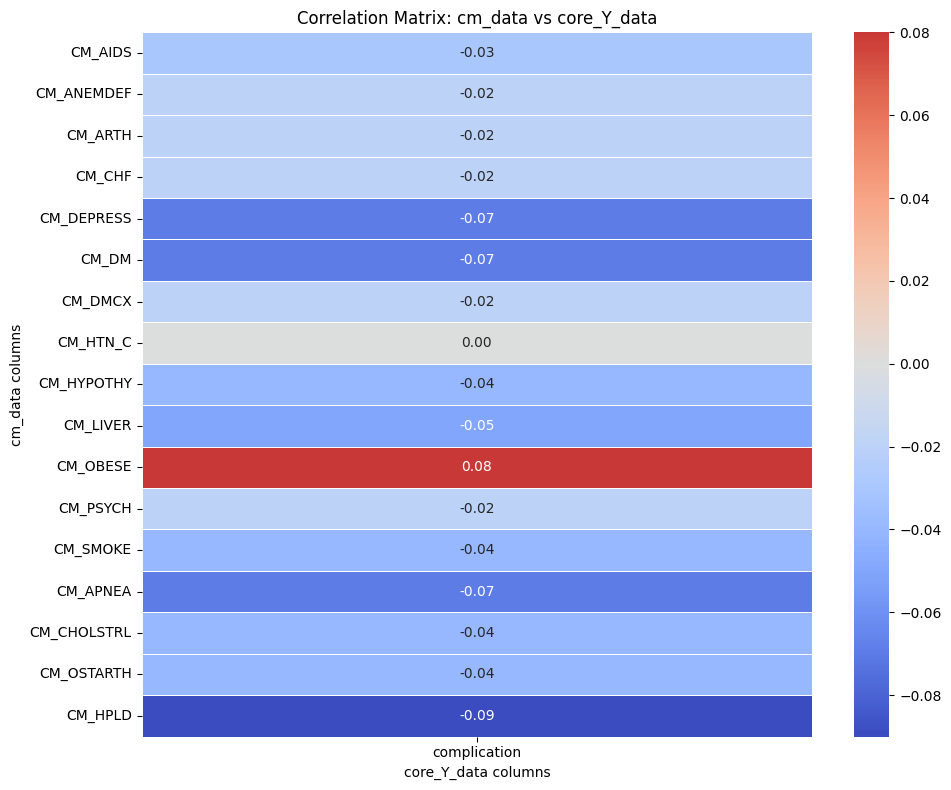

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume cm_data and core_Y_data are pandas DataFrames already loaded
# Create the correlation matrix
correlation_matrix = pd.DataFrame({
    y_col: cm_data.corrwith(core_Y_data[y_col]) 
    for y_col in core_Y_data.columns
})

# Round for cleaner display
correlation_matrix = correlation_matrix.round(2)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix: cm_data vs core_Y_data")
plt.xlabel("core_Y_data columns")
plt.ylabel("cm_data columns")
plt.tight_layout()
plt.show()
